functions - not oneliners
math - not just functions

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
warnings.filterwarnings('ignore')
data = pd.read_csv('''C:\\Users\\user\\Documents\\GitHub\\notebooks-on-ml\\Coursera lil proj\\DATA\\a_steam_data_2021_2025.csv''')

In [2]:
data['genres'] = data['genres'].fillna(data.groupby('categories')['genres'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))
data['genres'] = data['genres'].replace(['nan', 'None', ''], np.nan)
data['categories'] = data['categories'].replace(['nan', 'None', ''], np.nan)
data = data.dropna(subset=['genres', 'categories'])
data['developer'] = data['developer'].fillna('Noname')
data['publisher'] = data['publisher'].fillna('Noname')
data = data.sort_values(['release_date', 'developer']).reset_index(drop=True)
data['release_date'] = pd.to_datetime(data['release_date'], format='mixed', errors='coerce')
data['release_date'] = data['release_date'].fillna(pd.to_datetime('Aug 1 ' + data['release_year'].astype(str), format='%b %d %Y', errors='coerce'))       
data['genres'] = data['genres'].astype(str).str.split(';')
data['categories'] = data['categories'].astype(str).str.split(';')

In [3]:
data['is_sequel'] = data['name'].apply(lambda x: 1 if any(word.upper() in ['2', '3', 'II', 'III', 'IV', 'V'] for word in str(x).split()) else 0).astype(int)
data['developer&publisher'] = [1 if any(i in p for i in d) else 0 for d, p in zip(data['developer'], data['publisher'])]
data['is_indie_gem'] = ((data['recommendations'] > 200) & (data['price'] > 0)).astype(int)
data['genre_count'] = data['genres'].apply(len)
data['categories_count'] = data['categories'].apply(len)

data['niche'] = data['genres'].str[0] + '_' + data['categories'].str[0]
dev_gen_seen, dev_cat_seen = {}, {}
pub_gen_seen, pub_cat_seen = {}, {}
dg_hist, dc_hist, pg_hist, pc_hist = [], [], [], []

for d, p, g, c in zip(data['developer'], data['publisher'], data['genres'], data['categories']):
    d_key = tuple(d) if isinstance(d, list) else d
    p_key = tuple(p) if isinstance(p, list) else p
    
    dg_hist.append(list(dev_gen_seen.get(d_key, [])))
    dc_hist.append(list(dev_cat_seen.get(d_key, [])))
    pg_hist.append(list(pub_gen_seen.get(p_key, [])))
    pc_hist.append(list(pub_cat_seen.get(p_key, [])))
    
    dev_gen_seen.setdefault(d_key, set()).update(g)
    dev_cat_seen.setdefault(d_key, set()).update(c)
    pub_gen_seen.setdefault(p_key, set()).update(g)
    pub_cat_seen.setdefault(p_key, set()).update(c)

data['developer_genres'] = dg_hist
data['developer_categories'] = dc_hist
data['publisher_genres'] = pg_hist
data['publisher_categories'] = pc_hist
data['niche_pct'] = data.groupby('niche')['recommendations'].transform(lambda x: x.rank(pct=True))
data['is_niche_leader'] = (data['niche_pct'] > 0.90).astype(int)

In [4]:
data['log_price'] = np.log1p(data['price'])
data['log_recommendations'] = np.log1p(data['recommendations'])

In [5]:
data['is_hit'] = (data['recommendations'] > 800).astype(int)
#data['is_mega_hit'] = data['recommendations'] > 1800
data['is_discount'] = (data['price'] % 1 > 0.90).astype(int)
data['release_month'] = data['release_date'].dt.month
data['month_sin'] = np.sin(2 * np.pi * data['release_month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['release_month'] / 12)
data['genre_count'] = data['genres'].apply(len)
data['categories_count'] = data['categories'].apply(len)
data['niche'] = data['genres'].str[0] + '_' + data['categories'].str[0]
#data['price_per_genre'] = data['price'] / (data['genre_count'] + 1)

dev_stats = {}
pub_stats = {}

res = {k: [] for k in [
    'dev_hit_ratio', 'pub_hit_ratio', 'dev_avg_price', 'pub_avg_price',
    'dev_std_price', 'pub_std_price', 'dev_avg_recs', 'pub_avg_recs',
    'dev_mom', 'pub_mom', 'dev_gen_h', 'dev_cat_h', 'pub_gen_h', 'pub_cat_h'
]}

for d, p, h, pr, rec, g, c in zip(data['developer'], data['publisher'], data['is_hit'], 
                                  data['price'], data['recommendations'], data['genres'], data['categories']):
    
    for ent, stats, pref in [(d, dev_stats, 'dev'), (p, pub_stats, 'pub')]:
        if ent not in stats:
            stats[ent] = [0, 0, 0.0, 0.0, 0.0, 0.0, set(), set(), 0]
        
        s = stats[ent]
        n = s[1]

        res[f'{pref}_hit_ratio'].append(s[0]/n if n>0 else 0)
        res[f'{pref}_avg_price'].append(s[2]/n if n>0 else 0)
        res[f'{pref}_avg_recs'].append(s[4]/n if n>0 else 0)
        res[f'{pref}_mom'].append(s[8] if n > 0 else 0)
        res[f'{pref}_gen_h'].append(list(s[6]))
        res[f'{pref}_cat_h'].append(list(s[7]))
        
        if n > 1:
            var = (s[3] / n) - (s[2] / n)**2
            res[f'{pref}_std_price'].append(np.sqrt(max(0, var)))
        else:
            res[f'{pref}_std_price'].append(0)

        s[0] += h
        s[1] += 1
        s[2] += pr
        s[3] += pr**2
        s[4] += rec
        s[8] = (rec - s[5]) if s[5] > 0 else 0
        s[5] = rec
        s[6].update(g)
        s[7].update(c)

data['developer_hit_ratio'] = res['dev_hit_ratio']
data['publisher_hit_ratio'] = res['pub_hit_ratio']
data['developer_price'] = res['dev_avg_price']
data['publisher_price'] = res['pub_avg_price']
data['developer_std'] = res['dev_std_price']
data['publisher_std'] = res['pub_std_price']
data['developer_recommendations'] = res['dev_avg_recs']
data['publisher_recommendations'] = res['pub_avg_recs']
data['developer_momentum'] = res['dev_mom']
data['publisher_momentum'] = res['pub_mom']
data['price_tier'] = pd.cut(data['price'], 
                            bins=[-1, 0.01, 9.99, 19.99, float('inf')], 
                            labels=[0, 1, 2, 3]).astype(int)

#data['unique_genres'] = [len(x) for x in res['dev_gen_h']]
#data['unique_categories'] = [len(x) for x in res['dev_cat_h']]

#data['developer_genre_overlap'] = [len(set(g) & set(h))/len(g) if len(g)>0 and h else 0 for g, h in zip(data['genres'], res['dev_gen_h'])]
#data['developer_category_overlap'] = [len(set(c) & set(h))/len(c) if len(c)>0 and h else 0 for c, h in zip(data['categories'], res['dev_cat_h'])]
#data['publisher_genre_overlap'] = [len(set(g) & set(h))/len(g) if len(g)>0 and h else 0 for g, h in zip(data['genres'], res['pub_gen_h'])]
#data['publisher_category_overlap'] = [len(set(c) & set(h))/len(c) if len(c)>0 and h else 0 for c, h in zip(data['categories'], res['pub_cat_h'])]

data['developer_game_number'] = data.groupby('developer').cumcount()
data['developer_game_number'] = data.groupby('developer')['developer_game_number'].shift(1).fillna(0).astype(int)
data['publisher_game_number'] = data.groupby('publisher').cumcount()
data['publisher_game_number'] = data.groupby('publisher')['publisher_game_number'].shift(1).fillna(0).astype(int)

data['publisher_niche_count'] = data.groupby(['publisher', 'niche']).cumcount()
data['publisher_niche_count'] = data.groupby(['publisher', 'niche'])['publisher_niche_count'].shift(1).fillna(0).astype(int)
data['developer_niche_count'] = data.groupby(['developer', 'niche']).cumcount()
data['developer_niche_count'] = data.groupby(['developer', 'niche'])['developer_niche_count'].shift(1).fillna(0).astype(int)

data['is_new_niche'] = ~data.duplicated(['developer', 'niche'])
data['total_niches_count'] = data.groupby('developer')['is_new_niche'].cumsum()
data['total_niches_count'] = data.groupby('developer')['total_niches_count'].shift(1).fillna(0).astype(int)
data['is_specialist'] = (data['total_niches_count'] <= 2).astype(int)

#data['is_veteran'] = (data['developer_niche_count'] >= 3).astype(int)
#data['timeliness'] = data['recommendations'] / ((2026 - data['release_date'].astype(str).str.split('-').str[0].astype(int)) * 12 - (data['release_date'].astype(str).str.split('-').str[1].astype(int) - 1)).replace(0, 1)
#data['quality'] = data['recommendations'] / (data['price'] + 0.001)
#data['developer_quality_ratio'] = data.groupby('developer')['quality'].transform(lambda x: x.shift(1).expanding().mean())
#data['publisher_quality_ratio'] = data.groupby('publisher')['quality'].transform(lambda x: x.shift(1).expanding().mean())
#data['developer_niche_recommendations'] = data.groupby(['developer', 'niche'])['recommendations'].transform(lambda x: x.shift(1).expanding().mean())
#data['publisher_niche_recommendations'] = data.groupby(['publisher', 'niche'])['recommendations'].transform(lambda x: x.shift(1).expanding().mean())

In [6]:
data['log_developer_price'] = np.log1p(data['developer_price'])
#data['log_publisher_price'] = np.log1p(data['publisher_price'])
data['log_developer_recommendations'] = np.log1p(data['developer_recommendations'])
data['log_publisher_recommendations'] = np.log1p(data['publisher_recommendations'])
#data['log_quality'] = np.log1p(data['quality'])
#data['log_developer_quality_ratio'] = np.log1p(data['developer_quality_ratio'])
#data['log_publisher_quality_ratio'] = np.log1p(data['publisher_quality_ratio'])
data['log_developer_momentum'] = np.sign(data['developer_momentum']) * np.log1p(np.abs(data['developer_momentum']))
#data['log_developer_niche_recommendations'] = np.log1p(data['developer_niche_recommendations'])
data['log_publisher_momentum'] = np.sign(data['publisher_momentum']) * np.log1p(np.abs(data['publisher_momentum']))
#data['log_publisher_niche_recommendations'] = np.log1p(data['publisher_niche_recommendations'])
data['log_total_niches_count'] = np.log1p(data['total_niches_count'])
data['log_developer_game_number'] = np.log1p(data['developer_game_number'])
data['log_publisher_game_number'] = np.log1p(data['publisher_game_number'])
data['log_developer_std'] = np.log1p(data['developer_std']) 
data['log_publisher_std'] = np.log1p(data['publisher_std'])

inf_counts = np.isinf(data.select_dtypes(include=[np.number])).sum()
print(inf_counts[inf_counts > 0])
print('----------------')
nan_counts = data.isnull().sum()
print(nan_counts[nan_counts > 0])

In [7]:
from sklearn.model_selection import train_test_split
X = data.drop(['is_hit', 'is_indie_gem', 'is_niche_leader'], axis=1)
y = data[['is_hit', 'is_indie_gem', 'is_niche_leader']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
split_idx = int(len(data) * 0.8)
X_train = data.iloc[:split_idx]
X_test = data.iloc[split_idx:]

In [8]:
robust_cols = [
    'log_price', 'log_developer_price',
    'log_developer_recommendations', 'log_publisher_recommendations', 
#    'log_quality', 'log_developer_quality_ratio', 'log_publisher_quality_ratio', 
#    'log_publisher_price', 'log_recommendations',
    'log_developer_momentum', 'log_publisher_momentum',
#    'log_developer_niche_recommendations', 'log_publisher_niche_recommendations',
    'developer_niche_count', 'publisher_niche_count',
#    'log_developer_count', 'log_publisher_count',
    'log_total_niches_count',
    'log_developer_std', 'log_publisher_std',
]
minmax_cols = [
#    'timeliness', 
    'genre_count', 'categories_count',  
#    'unique_genres', 'unique_categories',
#    'developer_category_overlap', 'publisher_category_overlap',
#    'developer_genre_overlap', 'publisher_genre_overlap',
    'month_sin', 'month_cos'
]
robust = RobustScaler()
mms = MinMaxScaler()
X_train[robust_cols] = robust.fit_transform(X_train[robust_cols])
y_train[minmax_cols] = mms.fit_transform(X_train[minmax_cols])
X_test[robust_cols] = robust.transform(X_test[robust_cols])
y_test[minmax_cols] = mms.transform(X_test[minmax_cols])

In [9]:
mlb_gen = MultiLabelBinarizer(sparse_output=True)
mlb_cat = MultiLabelBinarizer(sparse_output=True)

gen_sparse_train = mlb_gen.fit_transform(X_train['genres'])
cat_sparse_train = mlb_cat.fit_transform(X_train['categories'])

gen_sparse_test = mlb_gen.transform(X_test['genres'])
cat_sparse_test = mlb_cat.transform(X_test['categories'])

import scipy.sparse as sp
full_gen_sparse = sp.vstack([gen_sparse_train, gen_sparse_test])
full_cat_sparse = sp.vstack([cat_sparse_train, cat_sparse_test])

genre_df = pd.DataFrame.sparse.from_spmatrix(
    full_gen_sparse, 
    columns=mlb_gen.classes_, 
    index=data.index
)
category_df = pd.DataFrame.sparse.from_spmatrix(
    full_cat_sparse, 
    columns=mlb_cat.classes_, 
    index=data.index
)
mobile_cols = [c for c in category_df.columns if 'Remote Play on Phone' in c or 'Remote Play on Tablet' in c]
data['mobile'] = category_df[mobile_cols].any(axis=1).astype('int8')
data = pd.concat([data.drop(columns=['genres', 'categories']), genre_df, category_df], axis=1)

In [10]:
X = X + data.drop(columns=[
    'publisher', 'developer', 'price', 'name', 'niche', 'appid', 'release_date',
    'publisher_genres', 'publisher_categories', 'developer_genres', 'developer_categories',
    'publisher_price', 'developer_price', 'developer_recommendations', 'niche_pct',
    'publisher_recommendations', 'total_niches_count', 'developer_game_number', 
    'publisher_game_number', 'release_year', 'release_month', 'recommendations', 
    'Remote Play on Phone', 'Remote Play on Tablet', 'Online PvP', 'Family Sharing',
    'Online Co-op', 'Shared/Split Screen', 'publisher_std', 'developer_std', 'log_recommendations'
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
data.to_csv('''C:\\Users\\user\\Documents\\GitHub\\notebooks-on-ml\\Coursera lil proj\\DATA\\transition_file.csv''', index=False)

corr_matrix = data.select_dtypes(include=[np.number]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Redundant columns to drop: {to_drop}")

pairs = upper.unstack().dropna()
sorted_pairs = pairs.sort_values(ascending=False)
print("Top 10 most redundant pairs:")
print(sorted_pairs.head(10))

sns.scatterplot(x=data['publisher_std'], y=data['developer_std'])
plt.title("Visualizing Redundancy")
plt.show()

plt.figure(figsize=(15, 10))
subset = data.iloc[:, :30] 
sns.heatmap(subset.corr(), annot=False, cmap='coolwarm')
plt.show()

plot_data = data.explode('genres').explode('categories')
sns.barplot(data=plot_data, x='release_year', y='price')
plt.show()
sns.barplot(data=plot_data, x='release_year', y='recommendations')
plt.show()

timeline_data = plot_data.groupby(['release_year', 'genres']).size().reset_index(name='count')
timeline_data_2 = plot_data.groupby(['release_year', 'categories']).size().reset_index(name='count')
sns.lineplot(data=timeline_data, x='release_year', y='count', hue='genres')
plt.show()
sns.lineplot(data=timeline_data_2, x='release_year', y='count', hue='categories')
plt.show()

sns.barplot(data=plot_data, x='price', y='genres')
plt.show()
sns.barplot(data=plot_data, x='price', y='categories')
plt.show()
sns.barplot(data=plot_data, x='recommendations', y='genres')
plt.show()
sns.barplot(data=plot_data, x='recommendations', y='categories')
plt.show()

sns.histplot(data['price'], kde=True)
plt.show()
sns.histplot(data['recommendations'], kde=True)
plt.show()
sns.histplot(data['log_price'], kde=True)
plt.show()
sns.histplot(data['log_recommendations'], kde=True)
plt.show()

In [12]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('''C:\\Users\\user\\Documents\\GitHub\\notebooks-on-ml\\Coursera lil proj\\DATA\\transition_file.csv''')

In [13]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import optuna
from sklearn.model_selection import StratifiedKFold

base_models = [
    ('xgb', XGBClassifier(n_estimators=600, learning_rate=0.05, max_depth=5, use_label_encoder=False, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=3))
]
up_model = LogisticRegression(C=0.1, max_iter=1000)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
stack = StackingClassifier(
    estimators=base_models,
    final_estimator=up_model,
    cv=skf,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

In [14]:
multi_model = MultiOutputClassifier(stack, n_jobs=-1)
multi_model.fit(X_train, y_train)

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.A :term:`predict_proba` method will be exposed only if `estimator` implementsit.,StackingClass...redict_proba')
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",-1
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None


In [24]:
from sklearn.metrics import classification_report, f1_score
probs_train = multi_model.predict_proba(X_train)
probs_test = multi_model.predict_proba(X_test)
threshold = 0.1294
preds_train_list = []
preds_test_list = []
for i in range(len(probs_train)):
    train_col = (probs_train[i][:, 1] >= threshold).astype(int)
    test_col = (probs_test[i][:, 1] >= threshold).astype(int)
    preds_train_list.append(train_col)
    preds_test_list.append(test_col)

import numpy as np
preds_train = np.column_stack(preds_train_list)
preds_test = np.column_stack(preds_test_list)

for index, name in enumerate(['is_hit', 'is_indie_gem', 'is_niche_leader']):
    print(f'f\n=== Perfomance for: {name} ===')
    print(classification_report(y_test.iloc[:, index], preds_test[:, index]))
    
    train_f1 = f1_score(y_train.iloc[:, index], preds_train[:, index], average='macro')
    test_f1 = f1_score(y_test.iloc[:, index], preds_test[:, index], average='macro')
    
    print(f"--- Overfitting Check for {name} ---")
    print(f"Train Macro F1: {train_f1:.4f}")
    print(f"Test Macro F1:  {test_f1:.4f}")
    print(f"Gap:            {train_f1 - test_f1:.4f}")
    
    if (train_f1 - test_f1) > 0.10:
        print("RESULT: ⚠️ Overfitting detected (Model is memorizing).")
    else:
        print("RESULT: ✅ Model is stable (Generalizing well).")

f
=== Perfomance for: is_hit ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12557
           1       0.51      0.49      0.50       546

    accuracy                           0.96     13103
   macro avg       0.74      0.74      0.74     13103
weighted avg       0.96      0.96      0.96     13103

--- Overfitting Check for is_hit ---
Train Macro F1: 0.7778
Test Macro F1:  0.7408
Gap:            0.0370
RESULT: ✅ Model is stable (Generalizing well).
f
=== Perfomance for: is_indie_gem ===
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     11929
           1       0.47      0.67      0.55      1174

    accuracy                           0.90     13103
   macro avg       0.72      0.80      0.75     13103
weighted avg       0.92      0.90      0.91     13103

--- Overfitting Check for is_indie_gem ---
Train Macro F1: 0.7589
Test Macro F1:  0.7500
Gap:            0.0089
RESULT: ✅

corr = data.corr(numeric_only=True)['is_hit'].sort_values(ascending=False)
corr

import matplotlib.pyplot as plt

for i, target in enumerate(['is_hit', 'is_indie_gem', 'is_niche_leader']):
    current_stack = multi_model.estimators_[i]
    xgb_model = current_stack.estimators_[0]
    feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns)
    print(f"Top leak suspects for {target}:")
    print(feat_imp.sort_values(ascending=False).head(5))

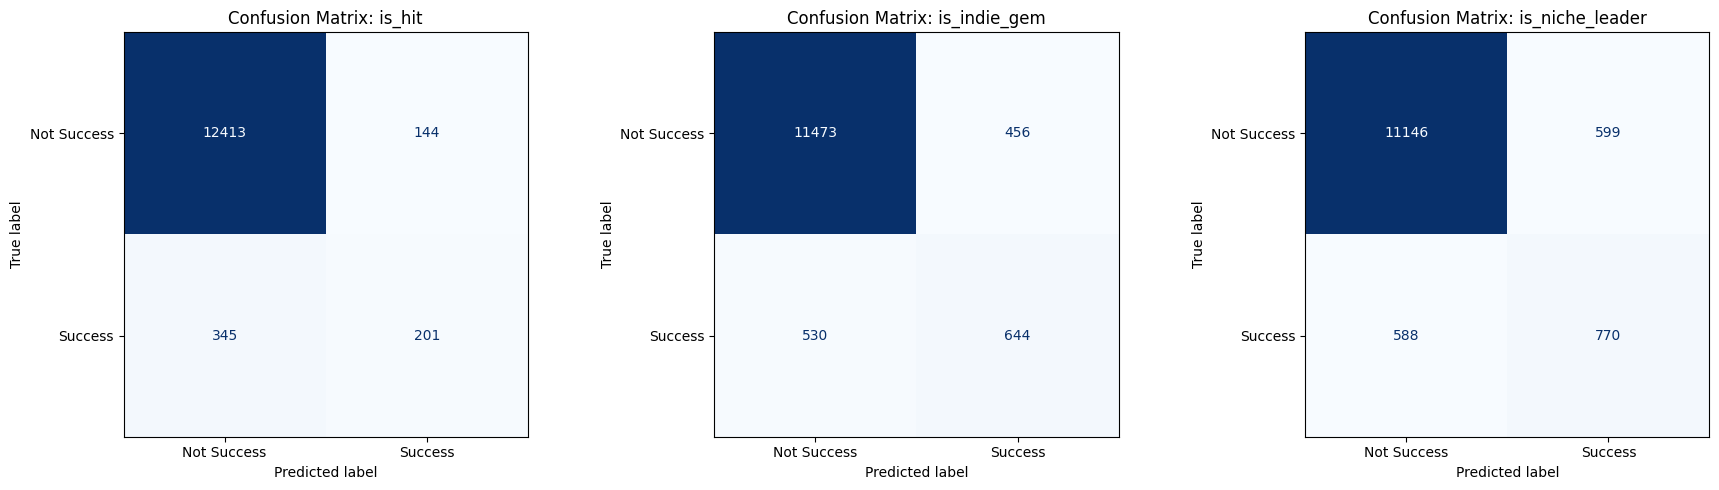

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
target_names = ['is_hit', 'is_indie_gem', 'is_niche_leader']
for i, name in enumerate(target_names):
    cm = confusion_matrix(y_test.iloc[:, i], preds_test[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Success', 'Success'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion Matrix: {name}')
plt.tight_layout()
plt.show()


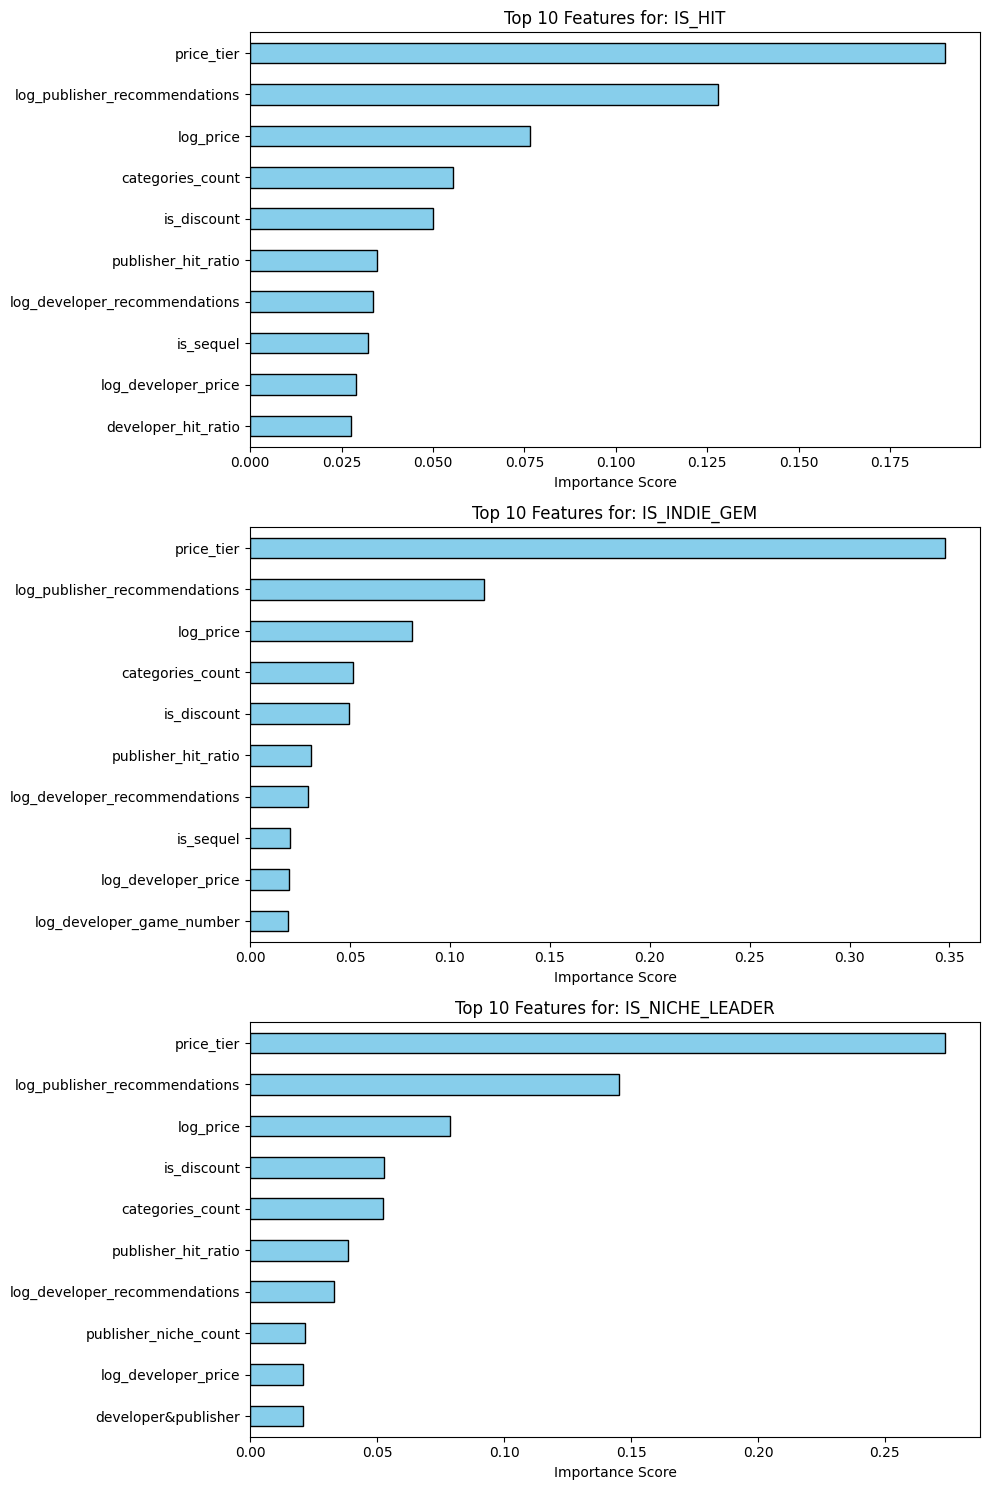


=== Meta-Model Weights (Who does the model trust more?) ===
is_hit: XGBoost Weight: 4.0919, RandomForest Weight: 4.3859
is_indie_gem: XGBoost Weight: 3.9195, RandomForest Weight: 3.7072
is_niche_leader: XGBoost Weight: 4.2060, RandomForest Weight: 3.0375


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
target_names = ['is_hit', 'is_indie_gem', 'is_niche_leader']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, name in enumerate(target_names):
    current_stack = multi_model.estimators_[i]
    xgb_model = current_stack.estimators_[0]
    feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns)
    top_10 = feat_imp.sort_values(ascending=True).tail(10)
    top_10.plot(kind='barh', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f"Top 10 Features for: {name.upper()}")
    axes[i].set_xlabel("Importance Score")
plt.tight_layout()
plt.show()

print("\n=== Meta-Model Weights (Who does the model trust more?) ===")
for i, name in enumerate(target_names):
    lr_model = multi_model.estimators_[i].final_estimator_
    coefs = lr_model.coef_[0]
    print(f"{name}: XGBoost Weight: {coefs[0]:.4f}, RandomForest Weight: {coefs[1]:.4f}")

In [18]:
def predict_new_game(name, price, genres_list, categories_list, developer_name, release_month=10):
    input_row = X.median().to_frame().T
    
    input_row['price'] = price
    input_row['log_price'] = np.log1p(price)
    input_row['month_sin'] = np.sin(2 * np.pi * release_month / 12)
    input_row['month_cos'] = np.cos(2 * np.pi * release_month / 12)

    dev_data = data[data['developer'] == developer_name]
    if not dev_data.empty:
        last_stats = dev_data.iloc[-1]
        for col in [c for c in X.columns if 'developer_' in c or 'publisher_' in c]:
            if col in last_stats:
                input_row[col] = last_stats[col]

    tag_cols = [c for c in X.columns if c in mlb_gen.classes_ or c in mlb_cat.classes_]
    input_row[tag_cols] = 0
    for g in genres_list:
        if g in input_row.columns: input_row[g] = 1
    for c in categories_list:
        if c in input_row.columns: input_row[c] = 1

    input_row[robust_cols] = robust.transform(input_row[robust_cols])
    input_row[minmax_cols] = mms.transform(input_row[minmax_cols])

    probs = multi_model.predict_proba(input_row)
    
    print(f"--- PREDICTION FOR: {name} ---")
    print(f"Hit Probability:          {probs[0][0][1]*100:.1f}%")
    print(f"Indie Gem Probability:    {probs[1][0][1]*100:.1f}%")
    print(f"Niche Leader Probability: {probs[2][0][1]*100:.1f}%")

predict_new_game(
    name="Super Strategy 2025", 
    price=19.99, 
    genres_list=['Strategy', 'Indie'], 
    categories_list=['Single-player', 'Steam Achievements'], 
    developer_name="Paradox Interactive"
)

--- PREDICTION FOR: Super Strategy 2025 ---
Hit Probability:          2.0%
Indie Gem Probability:    3.4%
Niche Leader Probability: 4.0%


In [19]:
from scipy import stats

indie_prices = data[data['Indie'] == 1]['price']
non_indie_prices = data[data['Indie'] == 0]['price']

t_stat, p_val = stats.ttest_ind(indie_prices, non_indie_prices)
print(f"P-value: {p_val}") 
print(f'Other-values: {t_stat}')

P-value: 1.1982172165892892e-52
Other-values: -15.284389786355773


In [20]:
from scipy.stats import chi2_contingency

table = pd.crosstab(data['Action'], data['is_hit'])
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-Square P-value: {p}")
print(f'Other-values: {chi2: .2f}, {dof}, {expected}')

Chi-Square P-value: 1.4824674806187325e-08
Other-values:  32.08, 1, [[38346.73309826  1429.26690174]
 [24810.26690174   924.73309826]]


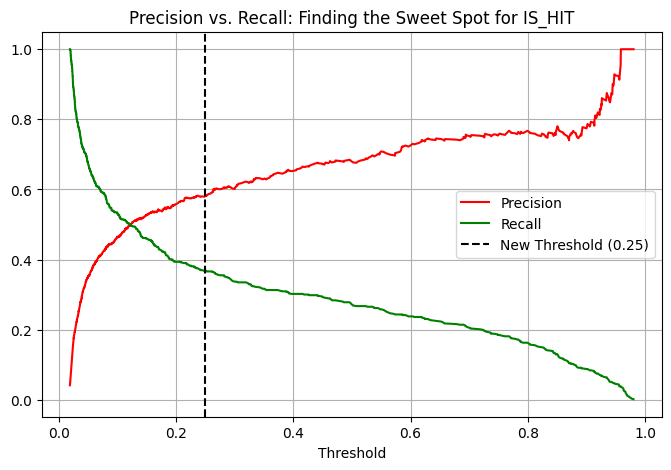

The 'Best Moment' Threshold: 0.1294
Resulting Precision: 0.5114
Resulting Recall: 0.4945


In [22]:
from sklearn.metrics import precision_recall_curve
hit_probs = multi_model.predict_proba(X_test)[0][:, 1]
precision, recall, thresholds = precision_recall_curve(y_test['is_hit'], hit_probs)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", color="red")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.axvline(x=0.25, color="black", linestyle="--", label="New Threshold (0.25)")
plt.xlabel("Threshold")
plt.title("Precision vs. Recall: Finding the Sweet Spot for IS_HIT")
plt.legend()
plt.grid(True)
plt.show()

y_scores = multi_model.predict_proba(X_test)[0][:, 1]
y_true = y_test['is_hit']
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-5)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"The 'Best Moment' Threshold: {best_threshold:.4f}")
print(f"Resulting Precision: {precisions[best_idx]:.4f}")
print(f"Resulting Recall: {recalls[best_idx]:.4f}")

In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
teacher_probs = multi_model.predict_proba(X_train)
soft_targets = np.column_stack([prob[:, 1] for prob in teacher_probs])
from sklearn.tree import DecisionTreeRegressor
student_model = DecisionTreeRegressor(max_depth=10) 
student_model.fit(X_train, soft_targets)
student_predictions = (student_model.predict(X_test) > 0.12).astype(int)

In [27]:
from sklearn.metrics import classification_report, f1_score
student_soft_preds = student_model.predict(X_test)
student_soft_train = student_model.predict(X_train)
best_threshold = 0.12
student_preds_test = (student_soft_preds > best_threshold).astype(int)
student_preds_train = (student_soft_train > best_threshold).astype(int)

for index, name in enumerate(['is_hit', 'is_indie_gem', 'is_niche_leader']):
    print(f'\n=== STUDENT Performance: {name} ===')
    print(classification_report(y_test.iloc[:, index], student_preds_test[:, index]))
    train_f1 = f1_score(y_train.iloc[:, index], student_preds_train[:, index], average='macro')
    test_f1 = f1_score(y_test.iloc[:, index], student_preds_test[:, index], average='macro')
    print(f"--- Student Overfitting Check ---")
    print(f"Train Macro F1: {train_f1:.4f}")
    print(f"Test Macro F1:  {test_f1:.4f}")
    print(f"Gap:            {train_f1 - test_f1:.4f}")


=== STUDENT Performance: is_hit ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     12557
           1       0.41      0.52      0.46       546

    accuracy                           0.95     13103
   macro avg       0.70      0.74      0.72     13103
weighted avg       0.96      0.95      0.95     13103

--- Student Overfitting Check ---
Train Macro F1: 0.7217
Test Macro F1:  0.7160
Gap:            0.0057

=== STUDENT Performance: is_indie_gem ===
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     11929
           1       0.41      0.73      0.52      1174

    accuracy                           0.88     13103
   macro avg       0.69      0.81      0.73     13103
weighted avg       0.92      0.88      0.89     13103

--- Student Overfitting Check ---
Train Macro F1: 0.7266
Test Macro F1:  0.7263
Gap:            0.0003

=== STUDENT Performance: is_niche_leader ===
              

In [30]:
def get_success_tier(prob):
    if prob >= 0.50:
        return "🥇 GOLD (High Certainty)"
    elif prob >= 0.25:
        return "🥈 SILVER (Strong Potential)"
    elif prob >= 0.12:
        return "🥉 BRONZE (Wildcard/Scout Alert)"
    else:
        return "❌ Low Probability"

sample_probs = student_model.predict(X_test[:5])
targets = ['is_hit', 'is_indie_gem', 'is_niche_leader']

for i, game_scores in enumerate(sample_probs):
    print(f"\n--- Analysis for Game {i+1} ---")
    for j, target_name in enumerate(targets):
        score = game_scores[j]
        tier = get_success_tier(score)
        print(f"{target_name:15}: {score:.2%} -> {tier}")


--- Analysis for Game 1 ---
is_hit         : 1.98% -> ❌ Low Probability
is_indie_gem   : 3.48% -> ❌ Low Probability
is_niche_leader: 3.95% -> ❌ Low Probability

--- Analysis for Game 2 ---
is_hit         : 2.65% -> ❌ Low Probability
is_indie_gem   : 7.23% -> ❌ Low Probability
is_niche_leader: 9.37% -> ❌ Low Probability

--- Analysis for Game 3 ---
is_hit         : 2.02% -> ❌ Low Probability
is_indie_gem   : 3.30% -> ❌ Low Probability
is_niche_leader: 3.79% -> ❌ Low Probability

--- Analysis for Game 4 ---
is_hit         : 2.04% -> ❌ Low Probability
is_indie_gem   : 3.84% -> ❌ Low Probability
is_niche_leader: 4.29% -> ❌ Low Probability

--- Analysis for Game 5 ---
is_hit         : 1.98% -> ❌ Low Probability
is_indie_gem   : 3.48% -> ❌ Low Probability
is_niche_leader: 3.95% -> ❌ Low Probability
